# Metric Testing

Test different metrics (loss functions) on their relative effectiveness in evaluating the true model specification.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from regime_switching.generate.arx import VARXGenerator

## Pick specification

In [3]:
gen = VARXGenerator.random_model(
    n=2, m=0, p_max=4, p_portion=0.7, 
    random_state=42
)

In [4]:
gen.endogenous.tolist(), gen.exogenous.tolist()

([0, 1], [])

In [5]:
y = gen.generate(100)

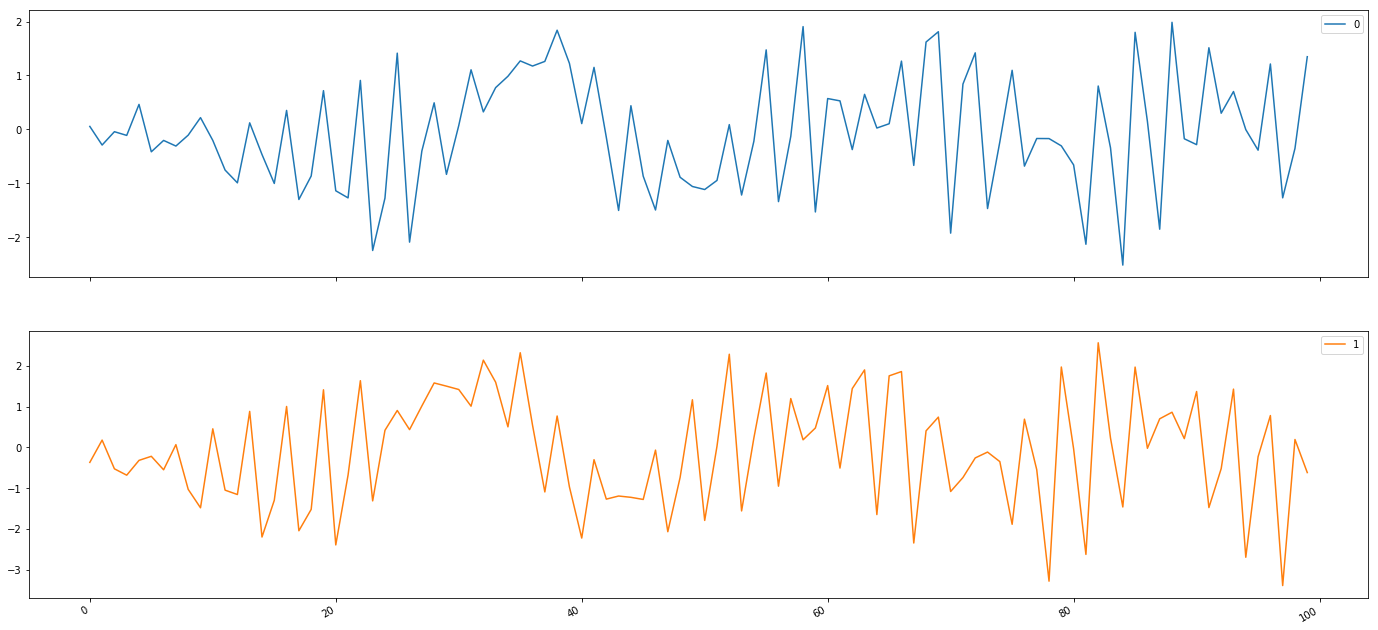

In [6]:
y.plot(subplots=True, figsize=(24, 12));

In [7]:
gen.coef_ar_df

0         1
lag                      
0   0 -0.265972 -0.266008
    1 -0.412875  0.799264
3   0  0.401673  0.562109
    1 -0.469123  0.954865